Airline Data Cleaning Setup

In [1]:
import pandas as pd
import numpy as np
import re

def clean_airline_data_final(df):
    """
    Cleans and standardizes the entire airline dataset.
    """
    # --- Step 1: Initial Cleaning & Column Names ---
    # Strip whitespace from column names to prevent KeyErrors
    df.columns = df.columns.str.strip()
    
    # Drop fully empty columns
    df.dropna(axis=1, how='all', inplace=True)
    
    # Clean simple numeric columns
    df['Number of Employees'] = pd.to_numeric(df['Number of Employees'].astype(str).str.replace(',', ''), errors='coerce')
    df['Passenger Load Factor (%)'] = pd.to_numeric(df['Passenger Load Factor (%)'].astype(str).str.replace('%', '').str.rstrip('.'), errors='coerce')

    # --- Step 2: Process Monetary & Seat-Km Columns ---
    monetary_cols = ['Revenue (PKR)', 'Operating Cost (PKR)', 'Fuel Cost', 'Net Profit/loss', 'EBIT']
    seat_km_cols = ['ASK (Avail Seat-km)', 'RPK (Rev Pax-km)']
    
    # A mapping to hold the new, clean column names we create
    new_column_map = {}

    def clean_monetary(value):
        """Parses monetary strings to extract value, currency, and handle multipliers."""
        value_str = str(value).lower().strip()
        is_negative = '(' in value_str and ')' in value_str
        
        # Determine currency
        currency = 'USD'
        if 'pkr' in value_str: currency = 'PKR'
        elif 'sgd' in value_str: currency = 'SGD'
        
        # Clean string for numeric conversion
        cleaned_str = value_str.replace('$', '').replace(',', '').replace('(', '').replace(')', '')
        cleaned_str = re.sub(r'[a-z/]+', '', cleaned_str).strip().rstrip('.')
        
        # Determine multiplier
        multiplier = 1
        if 'million' in value_str: multiplier = 1_000_000
        elif 'thousand' in value_str: multiplier = 1_000

        # Convert to numeric and apply sign/multiplier
        numeric_val = pd.to_numeric(cleaned_str, errors='coerce')
        if pd.notna(numeric_val):
            numeric_val *= multiplier
            if is_negative: numeric_val *= -1
        return numeric_val, currency

    # Create new cleaned columns from the raw monetary/seat-km data
    for col_name in monetary_cols + seat_km_cols:
        base_name = col_name.split(' ')[0].replace('(','_').replace(')','').lower()
        new_value_col = f"{base_name}_value"
        new_currency_col = f"{base_name}_currency"
        new_column_map[col_name] = {'value': new_value_col, 'currency': new_currency_col}
        
        temp_series = df[col_name].apply(clean_monetary)
        df[new_value_col] = temp_series.apply(lambda x: x[0])
        df[new_currency_col] = temp_series.apply(lambda x: x[1])

    # --- Step 3: Clean Budget, Convert to USD, and Finalize ---
    def clean_budget(value):
        """Parses the complex 'Major Campaign Budget' column with ranges."""
        value_str = str(value).lower().replace(',', '').replace('$', '').strip()
        if 'under' in value_str: return 1_000_000
        if '–' in value_str or '-' in value_str:
            parts = re.split('–|-', value_str)
            low = pd.to_numeric(re.sub(r'[^0-9.]', '', parts[0]), errors='coerce')
            high_str = re.sub(r'[^0-9.m]', '', parts[1])
            if 'm' in high_str:
                high = pd.to_numeric(high_str.replace('m',''), errors='coerce') * 1_000_000
            else:
                high = pd.to_numeric(high_str, errors='coerce')
                if low and low < 100: low *= 1_000_000
            return (low + high) / 2 if pd.notna(low) and pd.notna(high) else np.nan
        if 'm' in value_str:
            return pd.to_numeric(re.sub(r'[^0-9.]', '', value_str), errors='coerce') * 1_000_000
        return np.nan
        
    df['Major Campaign Budget'] = df['Major Campaign Budget'].apply(clean_budget)
    
    # Exchange rates for currency conversion
    exchange_rates = {
        'PKR_to_USD': {'2020': 0.006, '2021': 0.0062, '2022': 0.0048, '2023': 0.0035, '2024': 0.0036},
        'SGD_to_USD': {'2020': 0.72, '2021': 0.74, '2022': 0.72, '2023': 0.74, '2024': 0.74}
    }

    # Create the final USD-converted columns
    for col_name in monetary_cols:
        base_name = col_name.split(' ')[0].replace('(','_').replace(')','').lower()
        new_usd_col = f"{base_name}_usd"
        value_col = new_column_map[col_name]['value']
        currency_col = new_column_map[col_name]['currency']

        def convert_to_usd(row):
            """Applies the correct yearly exchange rate."""
            value, currency, year = row[value_col], row[currency_col], str(row['Year'])
            if pd.isna(value): return np.nan
            if currency == 'USD': return value
            rate = exchange_rates.get(f"{currency}_to_USD", {}).get(year)
            return value * rate if rate else np.nan
        
        df[new_usd_col] = df.apply(convert_to_usd, axis=1)

    # Drop the original, raw columns that have now been processed
    df.drop(columns=monetary_cols + seat_km_cols, inplace=True)
    
    return df

# --- Execution ---
# Load the raw data
df = pd.read_csv('Airline Data.csv')

# Run the final cleaning function
cleaned_df = clean_airline_data_final(df.copy())

# Save the result to a new CSV
cleaned_df.to_csv('Airline_Data_Cleaned.csv', index=False)

print("✅ Success! The data has been fully cleaned and standardized.")
print("The final dataset has been saved to 'Airline_Data_Cleaned.csv'.")
print("\nHere is a preview of your cleaned data:")
print(cleaned_df.head())

✅ Success! The data has been fully cleaned and standardized.
The final dataset has been saved to 'Airline_Data_Cleaned.csv'.

Here is a preview of your cleaned data:
  Airline  Year  Number of Employees  Liquidity Ratio  \
0     PIA  2024                 6625             0.38   
1     PIA  2023                 7326             0.09   
2     PIA  2022                 8031             0.13   
3     PIA  2021                 8558             0.14   
4     PIA  2020                10779             0.13   

   Passenger Load Factor (%)  Fleet Size  Frequent Flyer Program Strength  \
0                      81.81          32                                4   
1                      83.30          31                                4   
2                      80.28          29                                4   
3                      66.89          30                                4   
4                      74.46          30                                4   

   Brand Positioning  Major 

Cleaning the Data

✅ Generated analysis plot: budget_vs_revenue.png
✅ Generated analysis plot: brand_vs_profit.png
✅ Generated analysis plot: experience_vs_load_factor.png
✅ Generated analysis plot: flyer_program_vs_revenue.png

All marketing analysis visualizations have been generated and saved as PNG files.


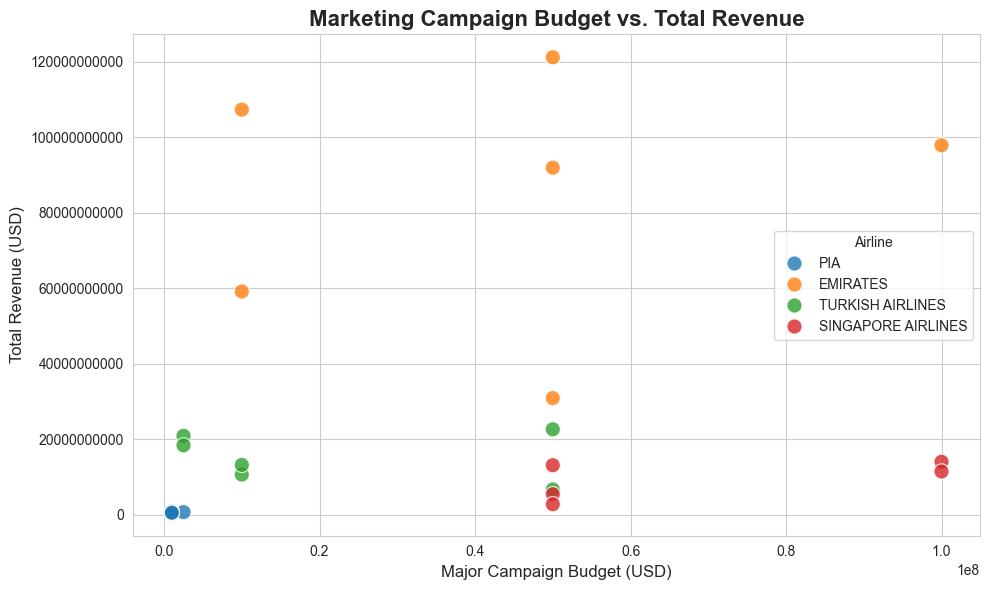

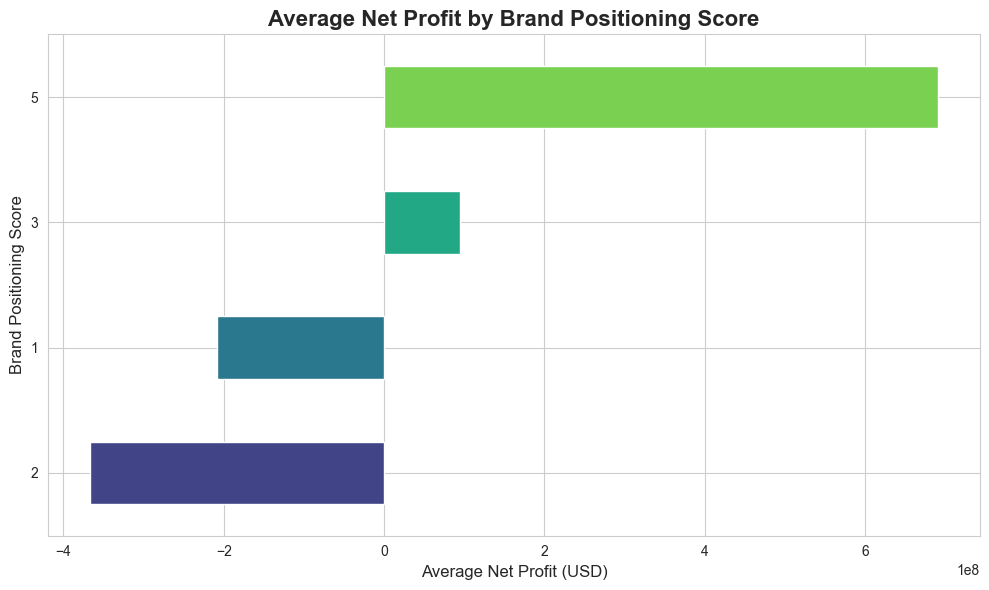

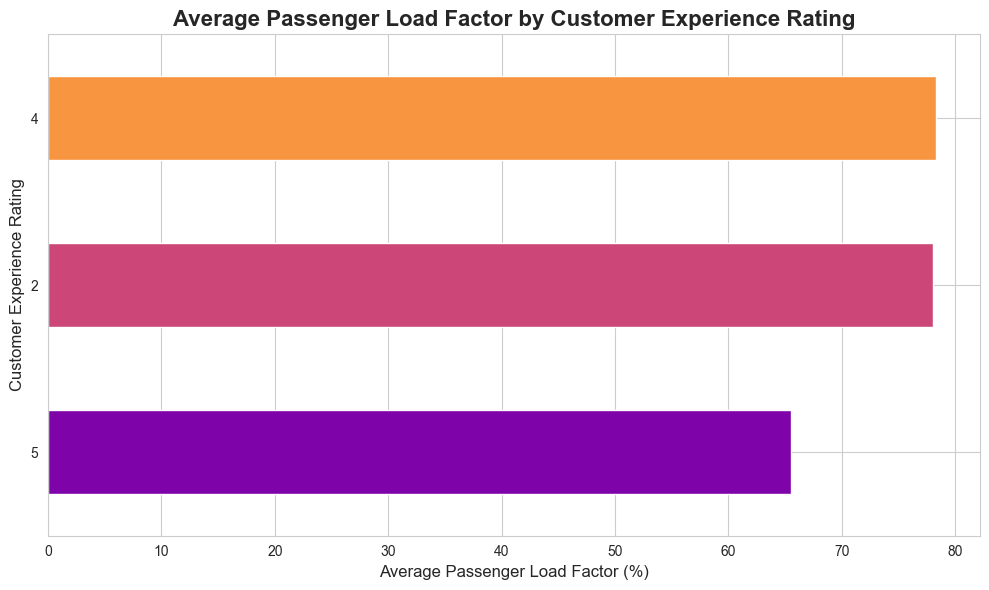

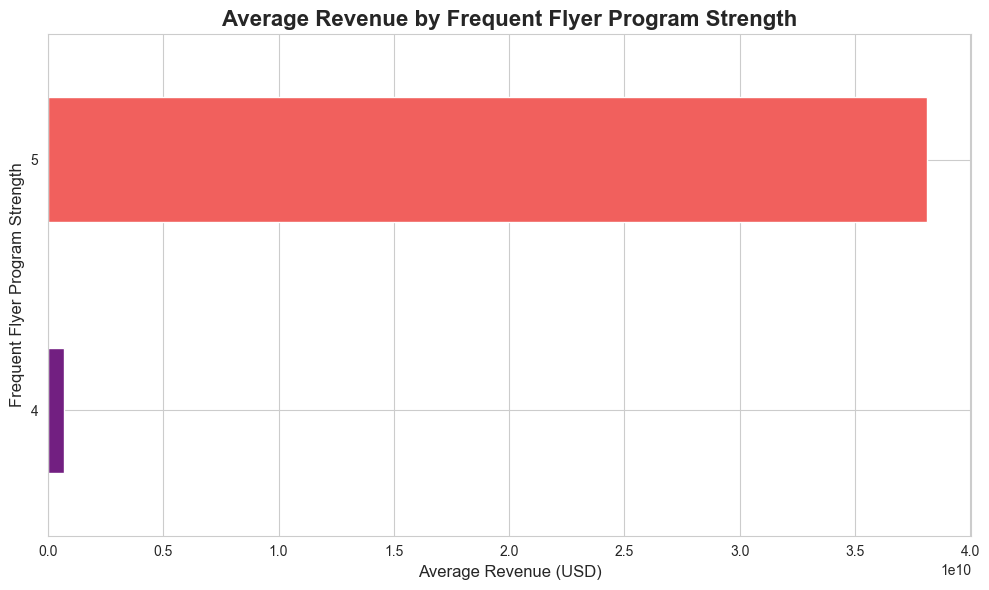

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
try:
    df = pd.read_csv('Airline_Data_Cleaned.csv')
except FileNotFoundError:
    print("Error: The cleaned file 'Airline_Data_Cleaned.csv' was not found.")
    print("Please make sure you have run the data cleaning script first.")
    # Exit the script if the file doesn't exist to prevent further errors.
    exit()

# Set a professional and clean style for all the plots
sns.set_style("whitegrid")

# --- Analysis 1: Marketing Budget vs. Revenue ---
# Create a scatter plot to see the relationship between marketing spend and revenue.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Major Campaign Budget', y='revenue_usd', hue='Airline', s=120, alpha=0.8)
plt.title('Marketing Campaign Budget vs. Total Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Major Campaign Budget (USD)', fontsize=12)
plt.ylabel('Total Revenue (USD)', fontsize=12)
# Format the y-axis to show plain numbers instead of scientific notation for readability.
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='Airline')
plt.tight_layout()
# Save the plot as a high-quality image file.
plt.savefig('budget_vs_revenue.png')
print("✅ Generated analysis plot: budget_vs_revenue.png")


# --- Analysis 2: Brand Positioning vs. Net Profit ---
# Group the data by 'Brand Positioning' and calculate the average net profit for each score.
brand_profit = df.groupby('Brand Positioning')['net_usd'].mean().sort_values()

# Create a horizontal bar chart for better readability of categories.
plt.figure(figsize=(10, 6))
brand_profit.plot(kind='barh', color=sns.color_palette("viridis", len(brand_profit)))
plt.title('Average Net Profit by Brand Positioning Score', fontsize=16, fontweight='bold')
plt.xlabel('Average Net Profit (USD)', fontsize=12)
plt.ylabel('Brand Positioning Score', fontsize=12)
plt.tight_layout()
plt.savefig('brand_vs_profit.png')
print("✅ Generated analysis plot: brand_vs_profit.png")


# --- Analysis 3: Customer Experience vs. Passenger Load Factor ---
# Group by 'Customer Experience Rating' to find the average load factor.
experience_load = df.groupby('Customer Experience Rating')['Passenger Load Factor (%)'].mean().sort_values()

plt.figure(figsize=(10, 6))
experience_load.plot(kind='barh', color=sns.color_palette("plasma", len(experience_load)))
plt.title('Average Passenger Load Factor by Customer Experience Rating', fontsize=16, fontweight='bold')
plt.xlabel('Average Passenger Load Factor (%)', fontsize=12)
plt.ylabel('Customer Experience Rating', fontsize=12)
plt.tight_layout()
plt.savefig('experience_vs_load_factor.png')
print("✅ Generated analysis plot: experience_vs_load_factor.png")


# --- Analysis 4: Frequent Flyer Program vs. Revenue ---
# Group by 'Frequent Flyer Program Strength' and calculate the average revenue.
flyer_revenue = df.groupby('Frequent Flyer Program Strength')['revenue_usd'].mean().sort_values()

plt.figure(figsize=(10, 6))
flyer_revenue.plot(kind='barh', color=sns.color_palette("magma", len(flyer_revenue)))
plt.title('Average Revenue by Frequent Flyer Program Strength', fontsize=16, fontweight='bold')
plt.xlabel('Average Revenue (USD)', fontsize=12)
plt.ylabel('Frequent Flyer Program Strength', fontsize=12)
plt.tight_layout()
plt.savefig('flyer_program_vs_revenue.png')
print("✅ Generated analysis plot: flyer_program_vs_revenue.png")

print("\nAll marketing analysis visualizations have been generated and saved as PNG files.")